In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [32]:
def calc_normalMap(depth_map):
    """calculate normal map from depth map

    Args:
        depth_map (ndarray): depth map

    Returns:
        ndarray: normal map
    """
    d_im = depth_map.astype("float64")
    zy, zx = np.gradient(d_im)  
    # You may also consider using Sobel to get a joint Gaussian smoothing and differentation
    # to reduce noise
    #zx = cv2.Sobel(d_im, cv2.CV_64F, 1, 0, ksize=5)     
    #zy = cv2.Sobel(d_im, cv2.CV_64F, 0, 1, ksize=5)

    normal = np.dstack((-zx, -zy, np.ones_like(d_im)))
    n = np.linalg.norm(normal, axis=2)
    normal[:, :, 0] /= n
    normal[:, :, 1] /= n
    normal[:, :, 2] /= n

    # offset and rescale values to be in 0-255
    normal += 1
    normal /= 2
    # if show, comment
    normal *= 255
    # cv2.imwrite("normal.png", normal[:, :, ::-1])
    return normal[:,:,::-1].copy()


In [2]:
def add_noise_Guass(img, mean=0, var=0.01):  # 添加高斯噪声
    img_copy = img.copy()
    img = (img / 255).astype(np.float64)
    noise = np.random.normal(mean, var ** 0.5, img.shape)
    out_img = img + noise
    out_img = np.clip(out_img, 0.0, 1.0)
    out_img[img_copy==0] = 0
    out_img = out_img * 255
    return out_img.astype(np.uint8)

In [8]:
path = '/home/rz/data/lock3dface/dataset_1028_new_no_aug/train_set/001_Kinect_FE_1DEPTH/01_depth_normal.png'
img = cv.imread(path)
img = img[:, :, 0, None]
img.shape
# normal = calc_normalMap(img[:, :, 0]).astype(np.uint8)
# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(img, cmap='gray')
# plt.subplot(1, 2, 2)
# plt.imshow(normal)

(128, 128, 1)

(128, 128, 3)


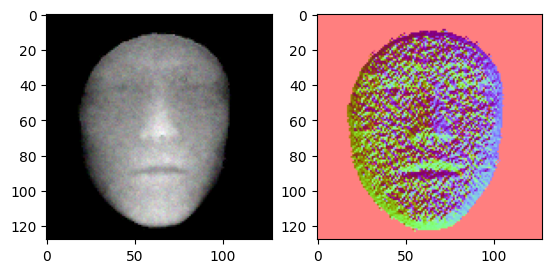

In [49]:
img_noisy = add_noise_Guass(img, var=0.001)
print(img_noisy.shape)
normal_noisy = calc_normalMap(img_noisy[:, :, 0]).astype(np.uint8)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img_noisy, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(normal_noisy)

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import datasets
import random
from torchvision import transforms
from PIL import Image
from utils import to_pixel_samples

In [2]:
def resize_fn(img, size):
    return transforms.ToTensor()(
        transforms.Resize(size, Image.BICUBIC)(
            transforms.ToPILImage()(img)))

In [3]:
spec = {
    'name': 'image-folder',
    'args': {
        'datafile': 'datafiles/lock3dface_test.txt',
        'augment': True,
        'repeat': 1
    }
}
dataset = datasets.make(spec)

In [4]:
x1, x2 = dataset[0]
x1.shape, x2.shape

(torch.Size([1, 128, 128]), torch.Size([1, 128, 128]))

In [5]:
def collect_fn(batch):
    noisy_imgs = []
    hr_coords, hr_gts, cells = [], [], []
    # 同一个batch进行相同的降采样
    s = random.uniform(1.0, 4.0)
    for data in batch:
        img_noisy, img_ori = data
        # downsample
        w_hr = img_ori.shape[-1]
        w_lr = round(w_hr / s)
        img_noisy_lr = resize_fn(img_noisy, w_lr)
        hr_coord, hr_gt = to_pixel_samples(img_ori)
        cell = torch.ones_like(hr_coord)
        cell[:, 0] *= 2 / w_hr
        cell[:, 1] *= 2 / w_hr
        hr_coords.append(hr_coord)
        hr_gts.append(hr_gt)
        cells.append(cell)

        noisy_imgs.append(img_noisy_lr)
    noisy_imgs = torch.stack(noisy_imgs, dim=0)
    hr_coords = torch.stack(hr_coords, dim=0)
    hr_gts = torch.stack(hr_gts, dim=0)
    cells = torch.stack(cells, dim=0)
    return {
        'inp': noisy_imgs,
        'coord': hr_coords,
        'cell': cells,
        'gt': hr_gts,
    }

In [6]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collect_fn)

In [7]:
batch = next(iter(dataloader))
batch['inp'].shape, batch['gt'].shape, batch['coord'].shape, batch['cell'].shape

/home/rz/miniconda3/envs/work/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/rz/miniconda3/envs/work/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(torch.Size([2, 1, 51, 51]),
 torch.Size([2, 16384, 1]),
 torch.Size([2, 16384, 2]),
 torch.Size([2, 16384, 2]))

In [1]:
import torch
import torch.nn.functional as F

# 定义一个函数，用于对图像进行resize
def resize_image(image, size):
   return F.interpolate(image, size=size, mode='bilinear', align_corners=False)

# 创建一个batch的图像
batch_size = 4
image_size = (3, 256, 256)
images = torch.randn(batch_size, *image_size)

# 对图像进行resize
resized_images = resize_image(images, (image_size[1] // 2, image_size[2] // 2))


In [2]:
resized_images.shape

torch.Size([4, 3, 128, 128])

# Grad CAM

In [3]:
import math

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import datasets
import models
import utils
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [4]:
spec = {
    'name': 'image-folder',
    'args': {
        'datafile': 'datafiles/lock3dface_test.txt',
        'augment': False,
        'repeat': 1,
        'num2id': 'datafiles/num2id_lock3d.npy'
    }
}
dataset = datasets.make(spec)
loader = DataLoader(dataset, batch_size=1,
    shuffle=False, num_workers=0, pin_memory=False,
    collate_fn=utils.random_downsample(scale_min=1, scale_max=8))

In [5]:
ckp_path = './save/lock3dface_ori_SR_1_8-no-id/epoch-best.pth'
sv_file = torch.load(ckp_path)
SR_model = models.make(sv_file['model'], load_sd=True).cuda()
ckp_path = '/home/rz/code/deep-denoising/save/led3d-experiment/0509-LED3D-SGD-ORI/epoch-best.pth'
sv_file = torch.load(ckp_path)
ID_model = models.make(sv_file['model'], load_sd=True).cuda()

In [6]:
# defines two global scope variables to store our gradients and activations 
gradients = None 
activations = None 

def backward_hook(module, grad_input, grad_output): 
    global gradients # refers to the variable in the global scope 
    print('Backward hook running...') 
    gradients = grad_output 
    # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8]) 
    print(f'Gradients size: {gradients[0].size()}')  
    # We need the 0 index because the tensor containing the gradients comes 
    # inside a one element tuple. 

def forward_hook(module, args, output): 
    global activations # refers to the variable in the global scope 
    print('Forward hook running...') 
    activations = output 
    # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8]) 
    print(f'Activations size: {activations.size()}')

In [7]:
backward_hook = ID_model.block5.register_full_backward_hook(backward_hook) 
forward_hook = ID_model.block5.register_forward_hook(forward_hook)

In [8]:
id_loss_fn = utils.CosineSimilarityLoss()
for batch in loader:
    for k, v in batch.items():
        batch[k] = v.cuda()
    inp = batch['inp']
    pred = SR_model(inp, batch['coord'], batch['cell'])
    gt = batch['gt']
    bs, n_coords, channels = gt.shape
    side = int(math.sqrt(n_coords))
    pred = pred.view(bs, side, side, channels).permute(0, 3, 1, 2)
    gt = gt.view(bs, side, side, channels).permute(0, 3, 1, 2)
    id_loss = utils.calc_id_loss(pred, gt, ID_model, id_loss_fn)
    id_loss.backward()
    break

/home/rz/miniconda3/envs/work/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/rz/miniconda3/envs/work/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Forward hook running...
Activations size: torch.Size([1, 960, 8, 8])
Forward hook running...
Activations size: torch.Size([1, 960, 8, 8])
Backward hook running...
Gradients size: torch.Size([1, 960, 8, 8])
Backward hook running...
Gradients size: torch.Size([1, 960, 8, 8])


In [9]:
pred_img = pred.cpu().detach().numpy().squeeze()

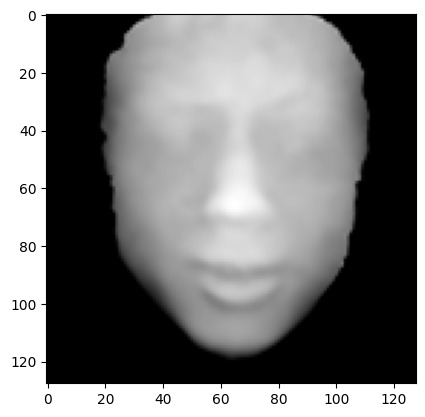

In [10]:
plt.imshow(pred_img, cmap='gray')

In [11]:
pooled_gradients = torch.mean(gradients[0], dim=[2, 3])
pooled_gradients = pooled_gradients.unsqueeze(2).unsqueeze(3)
pooled_gradients.shape

torch.Size([1, 960, 1, 1])

In [12]:
weighted_act = activations * pooled_gradients
weighted_act.shape

torch.Size([1, 960, 8, 8])

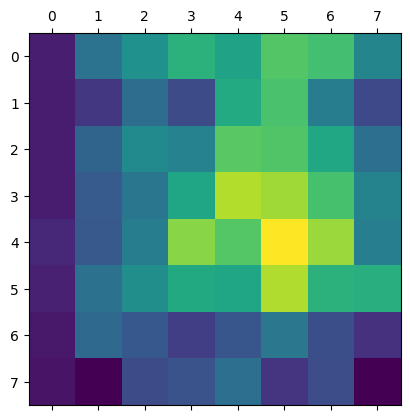

In [17]:
# average the channels of the activations 
heatmap = torch.mean(weighted_act, dim=1).squeeze() 

# relu on top of the heatmap 
heatmap = F.relu(heatmap) 

# normalize the heatmap 
heatmap /= torch.max(heatmap) 

# draw the heatmap 
plt.matshow(heatmap.detach().cpu())

In [18]:
heatmap.max()

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)

In [24]:
pred.squeeze(0).shape

torch.Size([1, 128, 128])

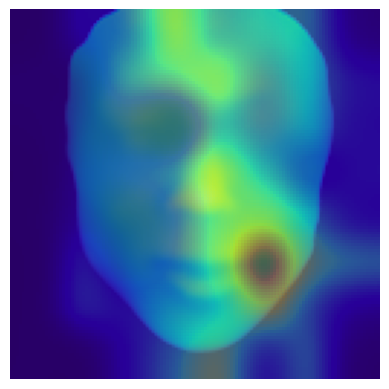

In [28]:
from torchvision.transforms.functional import to_pil_image 
from matplotlib import colormaps 
import numpy as np 
import PIL 

# Create a figure and plot the first image 
fig, ax = plt.subplots() 
ax.axis('off') # removes the axis markers 

# First plot the original image 
ax.imshow(to_pil_image(pred.squeeze(0)))
# ax.imshow(to_pil_image(pred.squeeze(0), mode='RGB')) 

# Resize the heatmap to the same size as the input image and defines 
# a resample algorithm for increasing image resolution 
# we need heatmap.detach() because it can't be converted to numpy array while 
# requiring gradients 
overlay = to_pil_image(heatmap.detach(), mode='F') \
                      .resize((128,128), resample=PIL.Image.BICUBIC) 

# Apply any colormap you want 
cmap = colormaps['jet'] 
overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8) 

# Plot the heatmap on the same axes,  
# but with alpha < 1 (this defines the transparency of the heatmap) 
ax.imshow(overlay, alpha=0.4, interpolation='nearest') 

# Show the plot 
plt.show()

In [37]:
r_heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), size=(128,128), mode='bilinear', align_corners=False)
r_heatmap.shape

torch.Size([1, 1, 128, 128])

In [40]:
s_r_heatmap = F.softmax(r_heatmap.view(-1), dim=0)

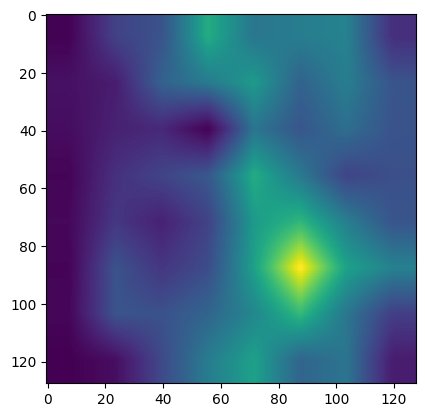

In [43]:
img = s_r_heatmap.view(128, 128).detach().cpu().numpy()
plt.imshow(img)

In [52]:
img.min()

4.2632724e-05

In [47]:
1 / 16384

6.103515625e-05

In [51]:
128*128

16384

In [2]:
import os

In [12]:
path = '/home/rz/data/lock3dface/dataset_1028_new_no_aug/test_set'
dir_names = os.listdir(path)
len(dir_names)

1850

In [13]:
train_imgs = []
selected_imgs = ['01_depth_normal.png', '11_depth_normal.png', '21_depth_normal.png',
                 '31_depth_normal.png', '41_depth_normal.png', '51_depth_normal.png']
for dir_name in dir_names:
    dir_path = os.path.join(path, dir_name)
    imgs = os.listdir(dir_path)
    for img in imgs:
        if img in selected_imgs:
            img_path = os.path.join(dir_path, img)
            train_imgs.append(img_path)
len(train_imgs)

11100

In [14]:
with open('datafiles/lock3dface_test_smplify.txt', mode='a') as f:
    for train_img in train_imgs:
        f.write(train_img + '\n')